# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for XResNet
#from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [4]:
from efficientnet_pytorch import *

In [5]:
from nb_new_data_augmentation_adacos_celltype_plategroup_exp import *

In [6]:
import pdb

In [7]:
__version__

'1.0.55'

# 6D image with celltype

In [8]:
class Image6Dct(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor, ctint, pgint, expint): # ct
        self._px = px
        self._logit_px=None
        #self.ct = ct
        self.ctint = ctint
        self.pgint = pgint
        self.expint = expint
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}
    
    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()
        
    def clone(self):
        "Mimic the behavior of torch.clone for `Image` objects."
        return self.__class__(self.px.clone(), self.ctint.clone(), self.pgint.clone(), self.expint.clone()) # self.ct.clone(), 

    @property
    def data(self)->TensorImage:
        "Return this images pixels as a tensor."
        return self.px, self.ctint, self.pgint, self.expint
    

In [9]:
def open_image_6Dct(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6Dct,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
    ct = fn.split('/')[1].split('-')[0] # get cell type
    ctint = torch.tensor(ct2int[ct])
    pgint = torch.tensor(fn2pgint[fn])
    exp = fn.split('/')[1] # get experiment
    expint = torch.tensor(exp2int[exp])
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x, ctint, pgint, expint)

In [10]:
# number experiments so that cell types do not overlap
# and the valid and test dataset do have a embedding they can use!
exp2int = {'HEPG2-01': 0,
           'HEPG2-02': 1,
           'HEPG2-03': 2,
           'HEPG2-04': 3,
           'HEPG2-05': 4,
           # valid
           'HEPG2-06': 0,
           'HEPG2-07': 1,
           # test
           'HEPG2-08': 0,
           'HEPG2-09': 1,
           'HEPG2-10': 2,
           'HEPG2-11': 3,           
             
           # train
           'HUVEC-01': 5,
           'HUVEC-02': 6,
           'HUVEC-03': 7,
           'HUVEC-04': 8,
           'HUVEC-05': 9,
           'HUVEC-06': 10,
           'HUVEC-07': 11, 
           'HUVEC-08': 12,
           'HUVEC-09': 13,
           'HUVEC-10': 14,
           'HUVEC-11': 15,
           'HUVEC-12': 16,
           'HUVEC-13': 17,
           'HUVEC-14': 18, 
           # valid
           'HUVEC-15': 5,
           'HUVEC-16': 6, 
           # test
           'HUVEC-17': 5,
           'HUVEC-18': 6,
           'HUVEC-19': 7,
           'HUVEC-20': 8,
           'HUVEC-21': 9,
           'HUVEC-22': 10,
           'HUVEC-23': 11,
           'HUVEC-24': 12,
             
           # train
           'RPE-01': 19,
           'RPE-02': 20,
           'RPE-03': 21,
           'RPE-04': 22,
           'RPE-05': 23,
           # valid
           'RPE-06': 19,
           'RPE-07': 20,
           # test
           'RPE-08': 19,
           'RPE-09': 20,
           'RPE-10': 21,
           'RPE-11': 22,
             
           # train
           'U2OS-01': 24,
           'U2OS-02': 25,
           # valid
           'U2OS-03': 24,
           # test
           'U2OS-04': 24,
           'U2OS-05': 25
          }

In [11]:
exp2int

{'HEPG2-01': 0,
 'HEPG2-02': 1,
 'HEPG2-03': 2,
 'HEPG2-04': 3,
 'HEPG2-05': 4,
 'HEPG2-06': 0,
 'HEPG2-07': 1,
 'HEPG2-08': 0,
 'HEPG2-09': 1,
 'HEPG2-10': 2,
 'HEPG2-11': 3,
 'HUVEC-01': 5,
 'HUVEC-02': 6,
 'HUVEC-03': 7,
 'HUVEC-04': 8,
 'HUVEC-05': 9,
 'HUVEC-06': 10,
 'HUVEC-07': 11,
 'HUVEC-08': 12,
 'HUVEC-09': 13,
 'HUVEC-10': 14,
 'HUVEC-11': 15,
 'HUVEC-12': 16,
 'HUVEC-13': 17,
 'HUVEC-14': 18,
 'HUVEC-15': 5,
 'HUVEC-16': 6,
 'HUVEC-17': 5,
 'HUVEC-18': 6,
 'HUVEC-19': 7,
 'HUVEC-20': 8,
 'HUVEC-21': 9,
 'HUVEC-22': 10,
 'HUVEC-23': 11,
 'HUVEC-24': 12,
 'RPE-01': 19,
 'RPE-02': 20,
 'RPE-03': 21,
 'RPE-04': 22,
 'RPE-05': 23,
 'RPE-06': 19,
 'RPE-07': 20,
 'RPE-08': 19,
 'RPE-09': 20,
 'RPE-10': 21,
 'RPE-11': 22,
 'U2OS-01': 24,
 'U2OS-02': 25,
 'U2OS-03': 24,
 'U2OS-04': 24,
 'U2OS-05': 25}

In [12]:
df_full_plate_pattern = pd.read_csv('full_dataset_v2_path_plate_groups_only_20190812.csv', index_col=0)

In [13]:
df_full_plate_pattern.head()

,path,plate_pattern
0,train/HEPG2-01/Plate1/B03_s1,0
1,train/HEPG2-01/Plate1/B04_s1,0
2,train/HEPG2-01/Plate1/B05_s1,0
3,train/HEPG2-01/Plate1/B06_s1,0
4,train/HEPG2-01/Plate1/B07_s1,0


In [14]:
fn2pgint = dict(zip(df_full_plate_pattern.path.values, 
                              df_full_plate_pattern.plate_pattern.values))

In [15]:
fn2pgint['train/HEPG2-01/Plate1/B03_s1']

0

In [16]:
# cell types from rcic_v10_inspect_image_data.ipynb "pixel stats"
cts = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']
int2ct = {i: ct for i, ct in enumerate(cts)}
ct2int = {ct: i for i, ct in int2ct.items()}

In [17]:
print(int2ct)
print(ct2int)

{0: 'HEPG2', 1: 'HUVEC', 2: 'RPE', 3: 'U2OS'}
{'HEPG2': 0, 'HUVEC': 1, 'RPE': 2, 'U2OS': 3}


In [18]:
ct = 'train/HEPG2-01/Plate1/B03_s1'.split('/')[1].split('-')[0]; ct

'HEPG2'

In [19]:
ct2int[ct]

0

In [20]:
PATH_trunc = 'train/HEPG2-01/Plate1/B03_s1' # path is missing suffix "_w1.png"

In [21]:
img = open_image_6Dct(PATH_trunc)

In [22]:
img.px.shape

torch.Size([6, 512, 512])

In [23]:
img.ctint, img.pgint, img.expint

(tensor(0), tensor(0), tensor(0))

In [24]:
type(img.ctint), type(img.pgint), type(img.expint)

(torch.Tensor, torch.Tensor, torch.Tensor)

# Dataset setup

In [25]:
class ImageList6Dct(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6Dct(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [26]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset raw files

In [27]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_ct_20190824.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_ct_20190824.csv', index_col=0)

In [28]:
df_train.shape

(73030, 6)

In [29]:
df_train.tail()

,path,experiment,sirna,multi,valid,celltype
36510,U2OS-03/Plate4/O19_s2,U2OS-03,103,U2OS-03 103,1,U2OS
36511,U2OS-03/Plate4/O20_s2,U2OS-03,202,U2OS-03 202,1,U2OS
36512,U2OS-03/Plate4/O21_s2,U2OS-03,824,U2OS-03 824,1,U2OS
36513,U2OS-03/Plate4/O22_s2,U2OS-03,328,U2OS-03 328,1,U2OS
36514,U2OS-03/Plate4/O23_s2,U2OS-03,509,U2OS-03 509,1,U2OS


In [30]:
df_test.tail()

,path,experiment,celltype
19892,U2OS-05/Plate4/O19_s2,U2OS-05,U2OS
19893,U2OS-05/Plate4/O20_s2,U2OS-05,U2OS
19894,U2OS-05/Plate4/O21_s2,U2OS-05,U2OS
19895,U2OS-05/Plate4/O22_s2,U2OS-05,U2OS
19896,U2OS-05/Plate4/O23_s2,U2OS-05,U2OS


In [31]:
#cts = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']

In [32]:
# Pick the celltype for the celltype-specific training
#ct = cts[3]; ct

In [33]:
#df_train[df_train['celltype'] == ct].shape

In [34]:
#df_train[df_train['celltype'] == ct].tail()

In [35]:
#df_test[df_test['celltype'] == ct].tail()

In [36]:
df_train['pg'] = df_train['path'].apply(lambda x: fn2pgint['train/'+x])

In [37]:
df_test['pg'] = df_test['path'].apply(lambda x: fn2pgint['test/'+x])

In [38]:
pg = 0

In [39]:
df_train[df_train['pg'] == pg].shape, df_test[df_test['pg'] == pg].shape

((18258, 7), (9958, 4))

In [40]:
df_train[df_train['pg'] == pg].tail()

,path,experiment,sirna,multi,valid,celltype,pg
35679,U2OS-03/Plate1/O19_s2,U2OS-03,764,U2OS-03 764,1,U2OS,0
35680,U2OS-03/Plate1/O20_s2,U2OS-03,1065,U2OS-03 1065,1,U2OS,0
35681,U2OS-03/Plate1/O21_s2,U2OS-03,301,U2OS-03 301,1,U2OS,0
35682,U2OS-03/Plate1/O22_s2,U2OS-03,757,U2OS-03 757,1,U2OS,0
35683,U2OS-03/Plate1/O23_s2,U2OS-03,831,U2OS-03 831,1,U2OS,0


In [41]:
df_test[df_test['pg'] == pg].tail()

,path,experiment,celltype,pg
19344,U2OS-05/Plate2/O19_s2,U2OS-05,U2OS,0
19345,U2OS-05/Plate2/O20_s2,U2OS-05,U2OS,0
19346,U2OS-05/Plate2/O21_s2,U2OS-05,U2OS,0
19347,U2OS-05/Plate2/O22_s2,U2OS-05,U2OS,0
19348,U2OS-05/Plate2/O23_s2,U2OS-05,U2OS,0


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [42]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [43]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [44]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [45]:
## EfficientNet-B3
#sz, bs = 300, 8 # 4167MiB /  7952MiB
sz, bs = 300, 8*2 # 7942MiB /  7952MiB // FP16: 4397MiB /  7952MiB
#sz, bs = 300, 8*4 # FP16: 7805MiB /  7952MiB

In [46]:
sz, bs

(300, 16)

In [47]:
# cutout params
#int(sz*0.1), int(sz*0.5)

In [48]:
# normal tfms
#tfms = get_transforms()

In [49]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [50]:
# extended tfms
#tfms = get_transforms(do_flip=True, flip_vert=True, 
#                      max_rotate=90.0, max_zoom=1.1, 
#                      max_lighting=0.2, max_warp=0.2, 
#                      p_affine=0.75, p_lighting=0.75, 
#                      xtra_tfms=[color_augmentation(), 
#                                 cutout(n_holes=(1,4), length=(int(sz*0.1), int(sz*0.5)), p=.5)])

In [51]:
#tfms = [[crop(size=sz, row_pct=(0,1), col_pct=(0,1))], []]

In [52]:
#tfms

In [ ]:
# change "crop_pad" from get_transforms to "crop"
# CENTER for FIXED cropping
tfms[0][0] = crop(size=sz, row_pct=[0.5,0.5], col_pct=[0.5,0.5])
tfms[1][0] = crop(size=sz, row_pct=[0.5,0.5], col_pct=[0.5,0.5])

In [53]:
# "crop_pad"
# NO FIXED CROPPING!!?
#tfms[0][0] = crop_pad(size=sz, row_pct=[0.,1.], col_pct=[0.,1.])
#tfms[1][0] = crop_pad(size=sz, row_pct=[0.,1.], col_pct=[0.,1.])

In [54]:
# train crop
tfms[0][0].kwargs['row_pct'], tfms[0][0].kwargs['col_pct']

([0.5, 0.5], [0.5, 0.5])

In [55]:
# valid crop
tfms[1][0].kwargs['row_pct'], tfms[1][0].kwargs['col_pct']

([0.5, 0.5], [0.5, 0.5])

In [56]:
#tfms

### Dataset definition

In [57]:
# VALID SPLIT (incl. tfms)
data = (ImageList6Dct.from_df(df_train[df_train['pg'] == pg], path='train')
        .split_from_df(col=-3) # FULL: .split_none() # !!!
        .label_from_df(cols=-5)
        .add_test(ImageList6Dct.from_df(df_test[df_test['pg'] == pg], path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [62]:
data

ImageDataBunch;

Train: LabelList (14386 items)
x: ImageList6Dct
Image6Dct (6, 300, 300),Image6Dct (6, 300, 300),Image6Dct (6, 300, 300),Image6Dct (6, 300, 300),Image6Dct (6, 300, 300)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (3872 items)
x: ImageList6Dct
Image6Dct (6, 300, 300),Image6Dct (6, 300, 300),Image6Dct (6, 300, 300),Image6Dct (6, 300, 300),Image6Dct (6, 300, 300)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (9958 items)
x: ImageList6Dct
Image6Dct (6, 300, 300),Image6Dct (6, 300, 300),Image6Dct (6, 300, 300),Image6Dct (6, 300, 300),Image6Dct (6, 300, 300)
y: EmptyLabelList
,,,,
Path: train

In [63]:
### CHANGED LINE 65 to:
# nano ~/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/data.py

```
~/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/data.py in _normalize_batch(b, mean, std, do_x, do_y)
     64     "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
     65     x,y = b
---> 66     mean,std = mean.to(x.device),std.to(x.device)
     67     if do_x: x = normalize(x,mean,std)
     68     if do_y and len(y.shape) == 4: y = normalize(y,mean,std)

AttributeError: 'list' object has no attribute 'device'
```
CHANGED TO:
```
def _normalize_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor, do_x:bool$
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    (x,cint,pgint,expint),y = b
    mean,std = mean.to(x.device),std.to(x.device)
    if do_x: x = normalize(x,mean,std)
    if do_y and len(y.shape) == 4: y = normalize(y,mean,std)
    return (x,cint,pgint,expint),y
```

In [64]:
#data.batch_stats() # DOES NOT WORK?

In [65]:
# From https://github.com/recursionpharma/rxrx1-utils/blob/master/rxrx/main.py
# The mean and stds for each of the channels
GLOBAL_PIXEL_STATS = (np.array([6.74696984, 14.74640167, 10.51260864,
                                10.45369445,  5.49959796, 9.81545561]),
                       np.array([7.95876312, 12.17305868, 5.86172946,
                                 7.83451711, 4.701167, 5.43130431]))

stats_mean = torch.tensor(GLOBAL_PIXEL_STATS[0]/255).float()
stats_var = torch.tensor(GLOBAL_PIXEL_STATS[1]/255).float()

In [66]:
#stats_mean, stats_var

In [67]:
data.normalize([stats_mean, stats_var]);

In [68]:
#data.batch_stats() # DOES NOT WORK?

In [69]:
data.batch_size

16

In [70]:
#data.stats # results is copied below
#[tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
# tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]

In [71]:
#data

In [72]:
data.c, len(data.classes), data.classes[-5:]

(277, 277, [1100, 1101, 1102, 1104, 1106])

In [73]:
data.train_ds[0]

(Image6Dct (6, 300, 300), Category 513)

In [74]:
#data.classes

In [75]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 129)

In [76]:
data.train_ds[0][0].ctint, data.train_ds[0][0].pgint, data.train_ds[0][0].expint

(tensor(0), tensor(0), tensor(0))

In [77]:
len(data.train_ds[0][0].data)

4

In [78]:
data.train_ds[0][0].data[0].shape, data.train_ds[0][0].data[1].shape, data.train_ds[0][0].data[2].shape

(torch.Size([6, 300, 300]), torch.Size([]), torch.Size([]))

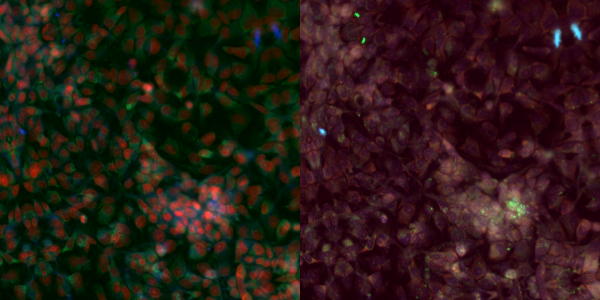

In [79]:
data.train_ds[0][0]

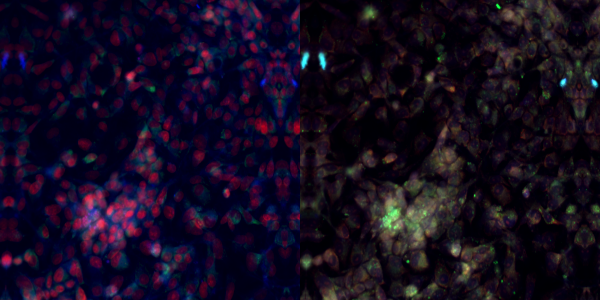

In [202]:
data.train_ds[0][0]

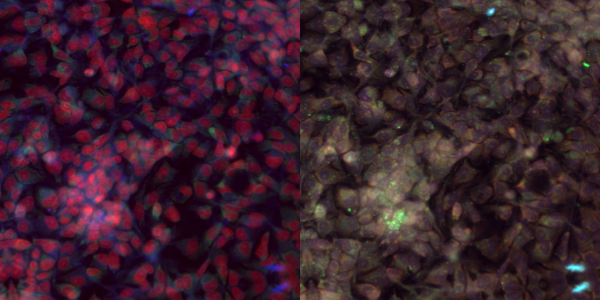

In [203]:
data.train_ds[0][0]

In [80]:
#data.train_ds[0][0].apply_tfms(crop(size=300, row_pct=(0,1), col_pct=(0,1)))

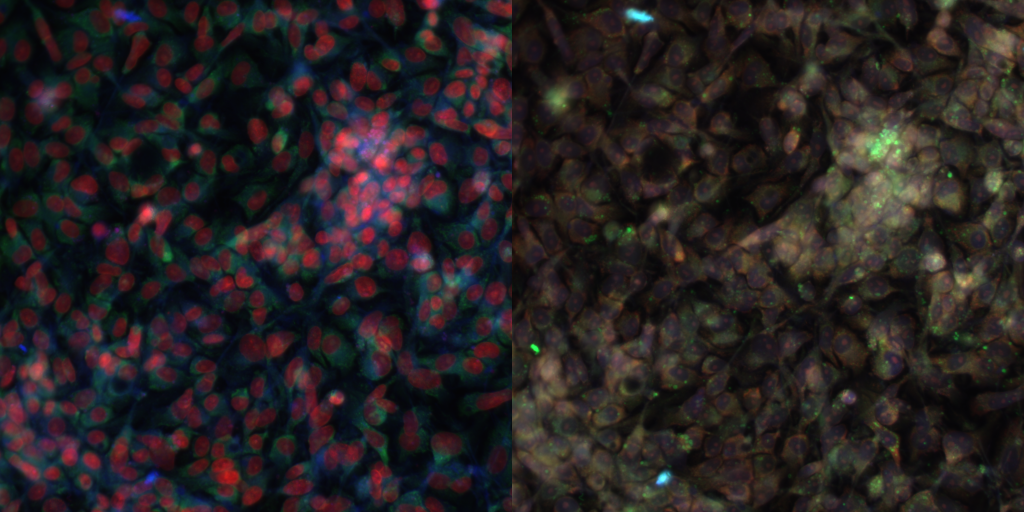

In [204]:
### ORIGINAL 512px NO TFMS
open_image_6Dct(data.train_ds.x.items[0])# .data[0].shape

# Model setup

## EfficientNet

In [82]:
# 3d to 6d from old/rcic_multicat_v9_resnet50-pretrained_colaug.ipynb

In [83]:
from efficientnet_pytorch.utils import get_same_padding_conv2d, round_filters, round_repeats, relu_fn
from efficientnet_pytorch.model import MBConvBlock, load_pretrained_weights

In [84]:
# put feature extractor into forward method
class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods
    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks
    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        #self._dropout = self._global_params.dropout_rate
        #self._fc = nn.Linear(out_channels, self._global_params.num_classes)

    def forward(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = relu_fn(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = relu_fn(self._bn1(self._conv_head(x)))

        return x

    #def forward(self, inputs):
    #    """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
    #
    #    # Convolution layers
    #    x = self.extract_features(inputs)
    #
    #    # Pooling and final linear layer
    #    x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
    #    if self._dropout:
    #        x = F.dropout(x, p=self._dropout, training=self.training)
    #    x = self._fc(x)
    #    return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return EfficientNet(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = EfficientNet.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000))
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet_b'+str(i) for i in range(num_models)]
        if model_name.replace('-','_') not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))

In [85]:
from torch.utils import model_zoo

In [86]:
url_map = {
    'efficientnet-b0': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b7-dcc49843.pth',
}

In [87]:
# adapt load function to only load weights for feature extractor stage
def load_pretrained_weights(model, model_name, load_fc=True):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = model_zoo.load_url(url_map[model_name])
    #if load_fc:
    #    model.load_state_dict(state_dict)
    #else:
    state_dict.pop('_fc.weight')
    state_dict.pop('_fc.bias')
    res = model.load_state_dict(state_dict, strict=False)
        #assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))

In [88]:
# b3: input size = 300
#efficientnet_b3 = EfficientNet.from_name('efficientnet-b3')
efficientnet_f = EfficientNet.from_pretrained('efficientnet-b3')
#efficientnet_b4f = EfficientNet.from_pretrained('efficientnet-b4')

Loaded pretrained weights for efficientnet-b3


In [89]:
#efficientnet_f

In [90]:
efficientnet_f._conv_stem, type(efficientnet_f._conv_stem)

(Conv2dStaticSamePadding(
   3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
   (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
 ), efficientnet_pytorch.utils.Conv2dStaticSamePadding)

In [91]:
utils.Conv2dStaticSamePadding(6, 40, kernel_size=(3, 3), stride=(2, 2), bias=False, image_size=300)

Conv2dStaticSamePadding(
  6, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
)

In [92]:
p_dict = {pn: p for pn, p in efficientnet_f._conv_stem.named_parameters()}

In [93]:
p_dict.keys()

dict_keys(['weight'])

In [94]:
p_dict['weight'].shape, p_dict['weight'].requires_grad

(torch.Size([40, 3, 3, 3]), True)

In [95]:
old_weight = p_dict['weight'].detach()

In [96]:
old_weight.shape, old_weight.requires_grad

(torch.Size([40, 3, 3, 3]), False)

In [97]:
new_weight = torch.cat((old_weight, old_weight), dim=1)

In [98]:
new_weight.shape, new_weight.requires_grad

(torch.Size([40, 6, 3, 3]), False)

In [99]:
def show_input_stage_weights(weight=None, nrows=2, ncols=3):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            if nrows > 1:
                ax[i,j].set_title(k)
                ax[i,j].imshow(weight[0][k])
                ax[i,j].axis("off")
            else:
                ax[j].set_title(k)
                ax[j].imshow(weight[0][k])
                ax[j].axis("off")
            k += 1

In [100]:
# plot old_weight
#show_input_stage_weights(old_weight, nrows=1)

In [101]:
# plot new_weight
#show_input_stage_weights(new_weight)

In [102]:
# replace first conv layer with a 6-channel version
efficientnet_f._conv_stem = utils.Conv2dStaticSamePadding(6, 40, kernel_size=(3, 3),
                                                          stride=(2, 2), bias=False, image_size=300)

In [103]:
efficientnet_f._conv_stem

Conv2dStaticSamePadding(
  6, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
)

In [104]:
efficientnet_f._conv_stem.weight.shape

torch.Size([40, 6, 3, 3])

In [105]:
# set new_weights to nn.Parameter and overwrite it in the conv layer
efficientnet_f._conv_stem.weight = nn.Parameter(new_weight) # hand over requires_grad False?

In [106]:
# check if weight was loaded properly
assert torch.allclose(new_weight, efficientnet_f._conv_stem.weight)

In [107]:
efficientnet_f._conv_stem.weight.shape, efficientnet_f._conv_stem.weight.requires_grad

(torch.Size([40, 6, 3, 3]), True)

In [108]:
# network is in full train mode!
#[p.requires_grad for p in efficientnet_b3f.parameters()]

In [109]:
def set_rg(model=efficientnet_f, option=False):
    for param in model.parameters():
        param.requires_grad = option

In [110]:
# set requires grad for the efficientnet to false (to later only set it true for the input)
# WE WILL NOT DO THIS, because it should be not necessary!
set_rg()

In [111]:
# network is frozen
#[p.requires_grad for p in efficientnet_b4f.parameters()]

In [112]:
efficientnet_f._conv_stem.weight.requires_grad

False

In [113]:
# set input stage to trainable
#efficientnet_f._conv_stem.weight.requires_grad = True

In [114]:
#efficientnet_f._conv_stem.weight.requires_grad

In [115]:
efficientnet_f(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 1536, 9, 9])

## EfficientNet Pre-Head

In [116]:
def resnet_pre_head(concat_pool:bool=True):
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    return nn.Sequential(*layers)

In [117]:
efficientnet_f_prehead = resnet_pre_head()

In [118]:
efficientnet_f_prehead

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
)

In [119]:
efficientnet_f_prehead(torch.randn(2, 1536, 9, 9)).shape

torch.Size([2, 3072])

In [120]:
efficientnet_fph = nn.Sequential(efficientnet_f, efficientnet_f_prehead)

In [121]:
efficientnet_fph(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 3072])

## CellType & Plate Group Feature Extractor

In [122]:
exps = len(set([exp2int[i] for i in exp2int])); exps

26

In [123]:
class CellTypePlateGroupFeatures(nn.Module):
    '''CellType Feature Extractor.'''
    def __init__(self, cell_types=4, plate_groups=4, exps=exps, emb_sz=128):
        super(CellTypePlateGroupFeatures, self).__init__()
        self.emb_ctint = nn.Embedding(cell_types, emb_sz)
        self.emb_pgint = nn.Embedding(plate_groups, emb_sz)
        self.emb_expint = nn.Embedding(exps, emb_sz)
        
    def forward(self, xb_ctint, xb_pgint, xb_expint, yb=None): # yb=None for training in non-AdaCos mode!
        
        ### CTINT
        # check if we are in CutMix mode:
        if isinstance(xb_ctint, tuple):
            x1, x2, λ = xb_ctint
            out1 = self.emb_ctint(x1)
            out2 = self.emb_ctint(x2)
            out_ctint = out1 * λ + out2 * (1-λ)
        else: # if not CutMix, then normal mode
            out_ctint = self.emb_ctint(xb_ctint)
        
        ## PGINT
        # check if we are in CutMix mode:
        if isinstance(xb_pgint, tuple):
            x1, x2, λ = xb_pgint
            out1 = self.emb_pgint(x1)
            out2 = self.emb_pgint(x2)
            out_pgint = out1 * λ + out2 * (1-λ)
        else: # if not CutMix, then normal mode
            out_pgint = self.emb_pgint(xb_pgint)
            
        ## EXPINT
        # check if we are in CutMix mode:
        if isinstance(xb_expint, tuple):
            x1, x2, λ = xb_expint
            out1 = self.emb_expint(x1)
            out2 = self.emb_expint(x2)
            out_expint = out1 * λ + out2 * (1-λ)
        else: # if not CutMix, then normal mode
            out_expint = self.emb_expint(xb_expint)
        
        out = torch.cat((out_ctint, out_pgint,  out_expint), dim=-1)
        
        return out

In [124]:
ctf = CellTypePlateGroupFeatures()

In [125]:
ctf

CellTypePlateGroupFeatures(
  (emb_ctint): Embedding(4, 128)
  (emb_pgint): Embedding(4, 128)
  (emb_expint): Embedding(26, 128)
)

In [126]:
xb = (torch.tensor(ct2int['HEPG2']),
      torch.tensor(fn2pgint['train/HEPG2-01/Plate1/B03_s1']),
      torch.tensor(exp2int['train/HEPG2-01/Plate1/B03_s1'.split('/')[1]])
     )

In [127]:
xb

(tensor(0), tensor(0), tensor(0))

In [128]:
ctf(xb[0], xb[1], xb[2]).shape

torch.Size([384])

In [129]:
xb = (torch.tensor((1,3)), torch.tensor((1,3)), torch.tensor((1,3)))

In [130]:
xb

(tensor([1, 3]), tensor([1, 3]), tensor([1, 3]))

In [131]:
ctf(xb[0], xb[1], xb[2]).shape

torch.Size([2, 384])

In [132]:
ct2int['HEPG2'], ct2int['RPE']

(0, 2)

In [133]:
fn2pgint['train/HEPG2-01/Plate1/B03_s1'], fn2pgint['train/RPE-01/Plate1/B03_s1']

(0, 0)

In [134]:
exp2int['HEPG2-01'], exp2int['RPE-01']

(0, 19)

In [135]:
xb = ((torch.tensor(ct2int['HEPG2']), torch.tensor(ct2int['RPE']), 0.9),
      (torch.tensor(fn2pgint['train/HEPG2-01/Plate1/B03_s1']),
       torch.tensor(fn2pgint['train/RPE-01/Plate1/B03_s1']), 0.9),
      (torch.tensor(exp2int['HEPG2-01']),
       torch.tensor(exp2int['RPE-01']), 0.9))

In [136]:
ctf(xb[0], xb[1], xb[2]).shape

torch.Size([384])

In [137]:
#class CellTypeFeatures(nn.Module):
#    '''CellType Feature Extractor.'''
#    def __init__(self, cell_types=4, emb_sz=128, lin_ftrs:Optional[Collection[int]]=None, nc=128):
#        super(AdaCosNet, self).__init__()
#        self.emb = nn.Embedding(cell_types, emb_sz)
#        
#        self.lin_ftrs = [emb_sz, 512, 512] if lin_ftrs is None else [emb_sz] + lin_ftrs + [nc]
#
#        
#    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
#
#        return out

## AdaCos-Head

In [138]:
def create_adacos_head(nf:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                bn_final:bool=False): # concat_pool:bool=True, nc:int,
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    
    # ADDED TWO MORE 512 LAYERS !!!
    lin_ftrs = [nf, 512, 512, 512, 512] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    # remove last 512 fc layer to reduce MODEL SIZE ??? ???
    
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    #pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    #layers = [pool, Flatten()]
    layers = []
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    #layers.append(AdaCos(lin_ftrs[-1], nc))
    return nn.Sequential(*layers)

In [139]:
#adacos_head = create_adacos_head(nf=2048+1) 
adacos_head = create_adacos_head(nf=1536*2+128*3)
# se_xresnet50f: 2048*2=4096, ctf: 128*3

In [140]:
adacos_head

Sequential(
  (0): BatchNorm1d(3456, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=3456, out_features=512, bias=True)
  (3): ReLU(inplace)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.25)
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): ReLU(inplace)
  (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.25)
  (10): Linear(in_features=512, out_features=512, bias=True)
  (11): ReLU(inplace)
  (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Dropout(p=0.5)
  (14): Linear(in_features=512, out_features=512, bias=True)
)

In [141]:
#adacos_head

In [142]:
adacos_head(torch.randn(2, 1536*2+128*3)).shape

torch.Size([2, 512])

In [171]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.We = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.We)

    def forward(self, xb, yb):
        
        #print(yb.shape)
        #pdb.set_trace()
        
        # normalize features
        x = F.normalize(xb)
        # normalize weights
        W = F.normalize(self.We)
        # dot product
        logits = F.linear(x, W)
        
        # for training in non-AdaCos mode (= no yb date in the forward pass):
        if yb is None:
            print('yb = None')
            return logits
        
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        
        # ORIGINAL
        #one_hot.scatter_(1, yb.view(-1, 1).long(), 1)
        #with torch.no_grad():
        #    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
        #    B_avg = torch.sum(B_avg) / xb.size(0)
        #    #print(B_avg)
        #    theta_med = torch.median(theta[one_hot == 1])
        #    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        #    #print(self.s)
            
        # ADAPTED FOR CUTMIX TO GET MIXED SCALE PARAMETER
        with torch.no_grad():
            # FROM nb_new_data_augmentation_adacos2.py LINE 888
            # AND https://github.com/fastai/fastai/blob/master/fastai/callbacks/mixup.py#L40
            if yb.ndim == 2:# and target.shape[-1] >1:
                n_mod_patches = (yb.shape[-1] - 1) // 2
                #c_ = yb[:, 1:n_mod_patches + 1]
                c_ = yb[:, 0:n_mod_patches + 1]
                W_ = yb[:, n_mod_patches + 1:]
                self.s_scaled = []
                
                # this loop is only realdy needed when we have different probabilities inside a batch
                # which we do not have (right now)! So this could be cleaned up, but we leave until
                # we know we will not need the case with different probabilities in a batch.
                for k in range(n_mod_patches+1):
                    yb_new = c_[:, k].long()
                    #pdb.set_trace()
                    
                    one_hot.scatter_(1, yb_new.view(-1,1).long(), 1)
                    
                    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                    B_avg = torch.sum(B_avg) / xb.size(0)
                    theta_med = torch.median(theta[one_hot == 1])
                    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
                    
                    if k+1 == len(range(n_mod_patches+1)):
                        #self.s_scaled.append((1-W_[:, k-1]) * self.s)
                        self.s_scaled.append((1-W_[0, k-1]) * self.s)
                        # For more than two the sum of W_[:, :k] has to be used!!!
                    else:
                        #self.s_scaled.append(W_[:, k] * self.s)
                        self.s_scaled.append(W_[0, k] * self.s)
                    # Mixed B_avg & self.s and single are not really far off, but now we have it coded
                    # se we keep it (until it breaks something later).
                self.s = torch.add(*self.s_scaled)
                # Clean up, self.s_scaled is just a vector with the same entry multiple times
                # when it is not indexed above with W_[0,... !
            else:
                one_hot.scatter_(1, yb.view(-1,1).long(), 1)
                B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                B_avg = torch.sum(B_avg) / xb.size(0)
                theta_med = torch.median(theta[one_hot == 1])
                self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        
        output = self.s * logits

        return output

## Network

In [172]:
class AdaCosNet(nn.Module):
    '''Simple AdaCosNet connecter to run xb through the feature extractor head
    and then feed xb and yb into the AdaCos layer.'''
    def __init__(self, body1, body2, head):
        super(AdaCosNet, self).__init__()
        self.body1 = body1
        self.body2 = body2
        self.head = head
        self.adacos = AdaCos(512, 277) # was 1108 !!!
        
    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
        xb_img, xb_ctint, xb_pgint, xb_expint = xb
        resnet_features = self.body1(xb_img)
        int_features = self.body2(xb_ctint, xb_pgint, xb_expint)
        features = torch.cat((resnet_features, int_features), dim=-1)
        out = self.head(features)
        #print('xb.shape: ', xb.shape,', yb.shape: ', yb.shape)
        out = self.adacos(out, yb)
        #print('out: ',out.shape)
        #pdb.set_trace()
        return out

In [173]:
adacos_efficientnet = AdaCosNet(efficientnet_fph, ctf, adacos_head)

In [174]:
xb = (torch.randn(2,6,sz,sz),
      #(torch.randint(4, (2,1)),  torch.randint(4, (2,1)))
      torch.tensor((1,3)), torch.tensor((1,3)), torch.tensor((1,3))
     )

In [ ]:
adacos_efficientnet(xb).shape

In [ ]:
adacos_efficientnet(xb, torch.tensor([276, 1])).shape

In [164]:
test_target = torch.tensor(
    [[2.4700e+02, 2.3900e+02, 7.8362e-01],
     [2.3300e+02, 1.7400e+02, 7.8362e-01],
     [1.7400e+02, 1.3400e+02, 7.8362e-01],
     [1.9800e+02, 1.4700e+02, 7.8362e-01]])

In [ ]:
adacos_efficientnet((torch.randn(4,6,sz,sz), 
                     torch.tensor((1,3,0,2)), torch.tensor((1,3,0,2)), torch.tensor((1,3,0,2))),
                    test_target).shape

In [177]:
# Based on https://forums.fast.ai/t/teacher-forcing/29415/4
# https://forums.fast.ai/t/on-batch-begin-callback/35201/3
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self, learn):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

# Training

## EfficientNet

In [178]:
learn = Learner(data, adacos_efficientnet, metrics=[accuracy],
                callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()

In [ ]:
# https://github.com/pytorch/pytorch/issues/7455
#class LabelSmoothingLoss(nn.Module):
#    def __init__(self, classes, smoothing=0.0, dim=-1):
#        super(LabelSmoothingLoss, self).__init__()
#        self.confidence = 1.0 - smoothing
#        self.smoothing = smoothing
#        self.cls = classes
#        self.dim = dim
#
#    def forward(self, pred, target):
#        pred = pred.log_softmax(dim=self.dim)
#        with torch.no_grad():
#            # true_dist = pred.data.clone()
#            true_dist = torch.zeros_like(pred)
#            true_dist.fill_(self.smoothing / (self.cls - 1))
#            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
#        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
#labsmooth_loss = LabelSmoothingLoss(1108, 0.1)

In [ ]:
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.empty(3, dtype=torch.long).random_(5)
#labsmooth_loss(input, target)

In [ ]:
learn.loss_func

In [ ]:
#learn.loss_func = labsmooth_loss
#learn.loss_func

In [ ]:
learn.opt_func

In [ ]:
# https://docs.fast.ai/callbacks.fp16.html
#learn.to_fp16(loss_scale=512, clip=1e3);

In [ ]:
# Make Adam FP16 proof:
# https://forums.fast.ai/t/mixed-precision-training/29601/21
# https://discuss.pytorch.org/t/adam-half-precision-nans/1765
# https://vxlabs.com/2019/02/04/improving-fastais-mixed-precision-support-with-nvidias-automatic-mixed-precision/
#learn.opt_func = partial(learn.opt_func, eps=1e-4)
#learn.opt_func
#
### ADD CLIP PARAMETER TOO???

In [ ]:
#learn.layer_groups

In [154]:
def check_rg(model=learn.model):
    layer_rg = [(n, p.requires_grad) for n,p in model.named_parameters()]
    for i in range(len(layer_rg)):
        print(f'{layer_rg[i][0]}\t{layer_rg[i][1]}'.expandtabs(45))

In [168]:
check_rg() # check where trainable

body1.0._conv_stem.weight                    False
body1.0._bn0.weight                          False
body1.0._bn0.bias                            False
body1.0._blocks.0._depthwise_conv.weight     False
body1.0._blocks.0._bn1.weight                False
body1.0._blocks.0._bn1.bias                  False
body1.0._blocks.0._se_reduce.weight          False
body1.0._blocks.0._se_reduce.bias            False
body1.0._blocks.0._se_expand.weight          False
body1.0._blocks.0._se_expand.bias            False
body1.0._blocks.0._project_conv.weight       False
body1.0._blocks.0._bn2.weight                False
body1.0._blocks.0._bn2.bias                  False
body1.0._blocks.1._depthwise_conv.weight     False
body1.0._blocks.1._bn1.weight                False
body1.0._blocks.1._bn1.bias                  False
body1.0._blocks.1._se_reduce.weight          False
body1.0._blocks.1._se_reduce.bias            False
body1.0._blocks.1._se_expand.weight          False
body1.0._blocks.1._se_expand.bi

In [ ]:
# unfreeze network
#learn.unfreeze()
#set_rg(learn.model.body, option=True)

In [ ]:
#check_rg() # check where trainable

In [ ]:
#learn.summary()

### Train #1

In [179]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050_190823', strict=False);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.02E-02


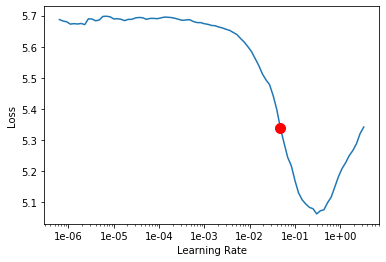

In [180]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                          name='effnet/adacos_efficientnet_b3_ct_pg_exp_'+ct+'e001-300_190827_bestXX')

In [181]:
#learn.fit_one_cycle(199, max_lr=1e-4, pct_start=0.2, final_div=1e3, callbacks=[savem])
learn.fit_one_cycle(50, max_lr=1e-2)#, callbacks=[savem])

epoch,train_loss,valid_loss,accuracy,time
0,2.254470,2.568992,0.575413,02:32
1,1.288088,2.082416,0.587810,02:24
2,1.226479,2.052638,0.593492,02:25
3,1.228321,2.067503,0.583419,02:24
4,1.222752,2.072124,0.587810,02:23
5,1.220291,2.099213,0.589360,02:24
6,1.218310,2.151546,0.575413,02:26
7,1.283400,2.126791,0.585227,02:24
8,1.225647,2.158138,0.586777,02:25
9,1.220030,2.186430,0.571798,02:26


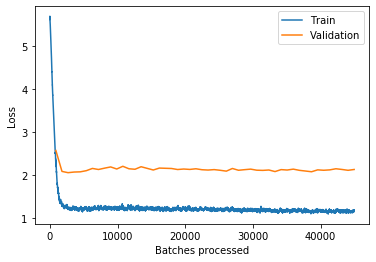

In [182]:
learn.recorder.plot_losses()

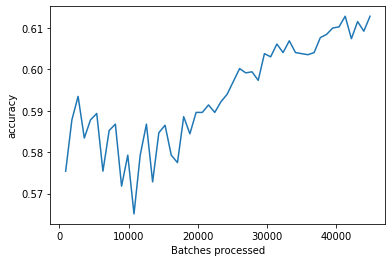

In [183]:
learn.recorder.plot_metrics()

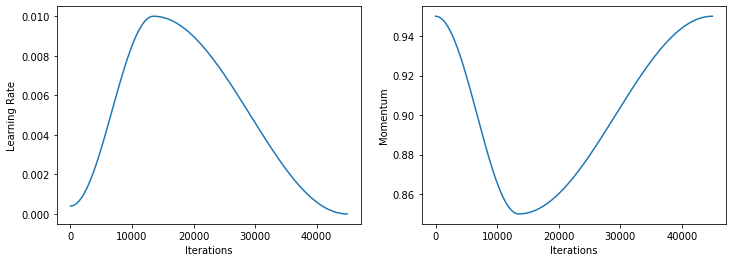

In [184]:
learn.recorder.plot_lr(show_moms=True)

In [188]:
learn.save('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050pg'+str(pg)+'e050_190901')

In [189]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050pg'+str(pg)+'e050_190901');

In [ ]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

### Train #2

In [190]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050pg'+str(pg)+'e050_190901');

In [191]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 6.31E-08


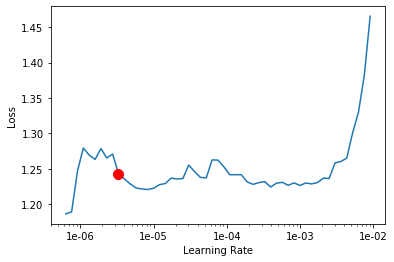

In [192]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [193]:
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050pg'+str(pg)+'e050-100_190901_best')

In [194]:
#learn.fit_one_cycle(30, max_lr=1e-4, pct_start=0.2, final_div=1e3, callbacks=[savem])
learn.fit_one_cycle(50, max_lr=1e-4, callbacks=[savem])

epoch,train_loss,valid_loss,accuracy,time
0,1.139225,2.146107,0.611570,04:19
1,1.147232,2.082474,0.617769,04:21
2,1.169726,2.172346,0.611570,04:21
3,1.120245,2.146461,0.617769,04:21
4,1.132968,2.150350,0.625775,04:20
5,1.135856,2.134419,0.620351,04:21
6,1.157217,2.165522,0.623709,04:22
7,1.143124,2.254508,0.616477,04:22
8,1.180076,2.258925,0.629390,04:22
9,1.145510,2.200420,0.607438,04:21


Better model found at epoch 0 with accuracy value: 0.6115702390670776.
Better model found at epoch 1 with accuracy value: 0.6177685856819153.
Better model found at epoch 4 with accuracy value: 0.6257748007774353.
Better model found at epoch 8 with accuracy value: 0.6293904781341553.
Better model found at epoch 10 with accuracy value: 0.6348140239715576.
Better model found at epoch 24 with accuracy value: 0.6361053586006165.
Better model found at epoch 31 with accuracy value: 0.6363636255264282.
Better model found at epoch 32 with accuracy value: 0.6461777091026306.
Better model found at epoch 42 with accuracy value: 0.64824378490448.
Better model found at epoch 46 with accuracy value: 0.6500516533851624.


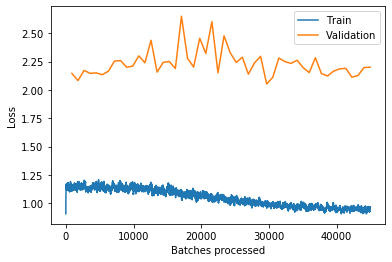

In [195]:
learn.recorder.plot_losses()

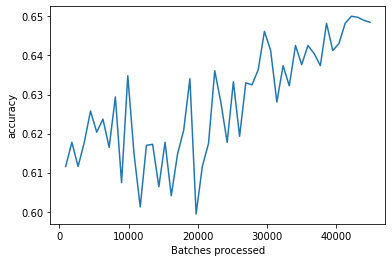

In [196]:
learn.recorder.plot_metrics()

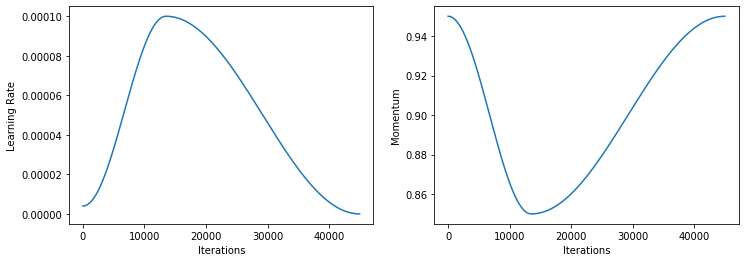

In [197]:
learn.recorder.plot_lr(show_moms=True)

In [199]:
learn.save('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050pg'+str(pg)+'e100_190901')

In [200]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050pg'+str(pg)+'e100_190901');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


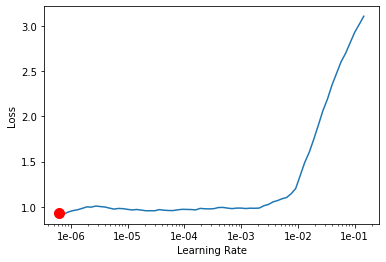

In [201]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

# Submission

## Classifcation

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729');

In [ ]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# check length
len(preds)

In [ ]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_cat})

In [ ]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [ ]:
# get row indices with the same/not the same the prediction for both sites
idx = [] # indices with the same prediction
idx_notsame = [] # indices with not the same prediction
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    if i % 2:
        # distance from row 2 is 
        if pred == r[1]['sirna']:
            idx.append(r[0])
        else:
            #idx.append(r[0]) # always append idx until we come up with something better
            idx.append(idx_row_before)
            idx_notsame.append(idx_row_before) # get the first rows of the pairs that are not the same
    else:
        # save dist from row 1 for comparison in next iteration
        pred = r[1]['sirna']
        idx_row_before = r[0]

In [ ]:
len(idx), len(idx_notsame)

In [ ]:
idx[:5]

In [ ]:
df_preds.sort_values('id_code').head(10)

In [ ]:
#df_preds.loc[idx,['id_code','sirna']]

In [ ]:
# 'effnet/adacos_efficientnet_b3_e080CM112_190805'
model = 'metriclearn_efficientnet_b3_e080CM112_190805'

In [ ]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


## Cosinus similarity

### Full single features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [ ]:
# extended tfms w/o color_augmentation !!!
#tfms = get_transforms(do_flip=True, flip_vert=True, 
#                      max_rotate=90.0, max_zoom=1.1, 
#                      max_lighting=0.2, max_warp=0.2, 
#                      p_affine=0.75, p_lighting=0.75)

In [ ]:
# change "crop_pad" from get_transforms to "crop"
# CENTER for FIXED cropping
tfms[0][0] = crop(size=sz, row_pct=[0.5,0.5], col_pct=[0.5,0.5])
tfms[1][0] = crop(size=sz, row_pct=[0.5,0.5], col_pct=[0.5,0.5])

In [ ]:
# RAND CROP_PAD?!!

In [ ]:
# train crop
tfms[0][0].kwargs['row_pct'], tfms[0][0].kwargs['col_pct']

In [ ]:
# valid crop
tfms[1][0].kwargs['row_pct'], tfms[1][0].kwargs['col_pct']

In [ ]:
#sz, bs = 300, 8*2*2 # 3436MiB /  7952MiB
#sz, bs = 300, 8*8 # 6884MiB /  7952MiB
sz, bs = 300, 8*11 # 7938MiB /  7952MiB

In [ ]:
# VALID SPLIT (incl. tfms)
data = (ImageList6Dct.from_df(df_train[df_train['celltype'] == ct], path='train')
        .split_from_df(col=-2) # !!!
        .label_from_df(cols=-4)
        .add_test(ImageList6Dct.from_df(df_test[df_test['celltype'] == ct], path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [ ]:
# FULL DATASET (incl. tfms)
data = (ImageList6Dct.from_df(df_train[df_train['celltype'] == ct], path='train')
        .split_none() # !!!
        .label_from_df(cols=-4)
        .add_test(ImageList6Dct.from_df(df_test[df_test['celltype'] == ct], path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [ ]:
data.normalize([stats_mean, stats_var]);

In [ ]:
ct

In [ ]:
#data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
#data.train_dl.dl.batch_sampler.drop_last = False
#
#data.valid_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.valid_ds)
#data.valid_dl.dl.batch_sampler.drop_last = False
#
## DOES WORK TOO FOR TEST DL ??? ??? (Or do we need to set the test dataset to the valid dataset?)
#data.test_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.test_ds)
#data.test_dl.dl.batch_sampler.drop_last = False

In [ ]:
learn = Learner(data, adacos_efficientnet)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_'+ct+'e300_190827');

In [ ]:
#def get_feats(model, dataloader, cycles=1):
#    feats = []
#    targs = []
#    model.eval()
#    with torch.no_grad():
#        for i in range(cycles): # for TTA
#            for xb, yb in dataloader:
#                body_out = model.body(xb)
#                head_out = model.head(body_out)
#                feats.append(head_out.cpu())
#                targs.append(yb.cpu())
#    return feats, targs

In [ ]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                xb_img, xb_ctint, xb_pgint, xb_expint = xb
                img_features = model.body1(xb_img)
                int_features = model.body2(xb_ctint, xb_pgint, xb_expint)
                features = torch.cat((img_features, int_features), dim=-1)
                out = model.head(features)
                feats.append(out.cpu())
                targs.append(yb.cpu())
    return feats, targs

In [ ]:
def get_img_exp_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    img_feats = []
    exp_input = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                xb_img, xb_ctint, xb_pgint, xb_expint = xb
                img_features = model.body1(xb_img)
                int_features = model.body2(xb_ctint, xb_pgint, xb_expint)
                features = torch.cat((img_features, int_features), dim=-1)
                out = model.head(features)
                feats.append(out.cpu())
                targs.append(yb.cpu())
                img_feats.append(img_features)
                exp_input.append(xb_expint.cpu())
    return feats, targs, img_feats, exp_input

#### Train

In [ ]:
feats, targs = get_feats(learn.model, learn.data.train_dl, cycles=3)
#feats, targs, img_feats, exp_input = get_img_exp_feats(learn.model, learn.data.train_dl)

In [ ]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)
#img_feats = torch.cat(img_feats, dim=0)
#exp_input = torch.cat(exp_input, dim=0)

In [ ]:
feats.shape, targs.shape

In [ ]:
np.save('pred/feats_train_'+ct+'.npy', feats)
np.save('pred/targs_train_'+ct+'.npy', targs)

#### Valid

In [ ]:
feats, targs = get_feats(learn.model, learn.data.valid_dl)

In [ ]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [ ]:
feats.shape, feats.shape, targs.shape

In [ ]:
np.save('pred/feats_valid_'+ct+'.npy', feats)
np.save('pred/targs_valid_'+ct+'.npy', targs)

#### Test

In [ ]:
feats, targs = get_feats(learn.model, learn.data.test_dl)

In [ ]:
del targs

In [ ]:
feats = torch.cat(feats, dim=0)

In [ ]:
feats.shape

In [ ]:
np.save('pred/feats_test_'+ct+'.npy', feats)

### Multi-crop features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
df_train['test'] = 0
df_train['path'] = 'train/'+df_train['path']

In [ ]:
df_train.head()

In [ ]:
# add dummy columns for test dataset
df_test['path'] = 'test/'+df_test['path']
df_test['test'] = 1
df_test['sirna'] = 1

In [ ]:
df_test.head()

In [ ]:
df_train_test = pd.concat((df_train, df_test), axis=0, sort=False)

In [ ]:
df_train_test.tail()

In [ ]:
# reload for train and valid ds
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [ ]:
# test tfms switching for test ds
#tfms_switched = (tfms[1], tfms[0])
#
#data = (ImageList6D.from_df(df_train_test, path='.')
#                .split_from_df(col=-1)
#                .label_from_df(cols=-4)
#                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#                .databunch(bs=bs))

In [ ]:
#data.train_ds[0][0]

In [ ]:
#data.valid_ds[0][0]

In [ ]:
def get_dataset(row_pct, col_pct, is_test=False):
    # extended tfms
    tfms = get_transforms(do_flip=True, flip_vert=True, 
                          max_rotate=90.0, max_zoom=1.1, 
                          max_lighting=0.2, max_warp=0.2, 
                          p_affine=0.75, p_lighting=0.75, 
                          xtra_tfms=[color_augmentation()])
    
    # change "crop_pad" from get_transforms to "crop"
    tfms[0][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    tfms[1][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    
    # VALID SPLIT (incl. tfms)
    if is_test:
        #switch train with valid (= test) tfms!
        tfms_switched = (tfms[1], tfms[0])
        
        data = (ImageList6D.from_df(df_train_test, path='.')
                .split_from_df(col=-1)
                .label_from_df(cols=-4)
                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    else:
        data = (ImageList6D.from_df(df_train, path='train')
                .split_from_df(col=-1) # split_by_rand_pct()
                .label_from_df(cols=-3)
                #.add_test(ImageList6D.from_df(df_test, path='test'))
                .transform(tfms)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    
    data.normalize([tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
                    tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]);
    
    return data

In [ ]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                body_out = model.body(xb)
                head_out = model.head(body_out)
                feats.append(head_out.cpu())
                targs.append(yb.cpu())
                
    feats = torch.cat(feats, dim=0)
    targs = torch.cat(targs, dim=0)
    
    return feats, targs

In [ ]:
def save_feats(feats, targs, crop, ds='train'):
    np.save(f'pred/feats_{ds}_crop{crop}.npy', feats)
    np.save(f'pred/targs_{ds}_crop{crop}.npy', targs)

In [ ]:
#https://docs.fast.ai/vision.transform.html#_crop
crop_pos = [[0.,0.], [0.,1.],[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
# get random crop pos
i = 2
crop_pos = [[uniform(0,1), uniform(0,1)] for i in range(2)]

In [ ]:
crop_pos

In [ ]:
# get the last three crop positions:
crop_pos = [[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
def get_crop_feats(model=learn.model, cycles=1, crop_pos=crop_pos):
    
    for i, (row_pct, col_pct) in enumerate(crop_pos):
        
        print('== crop#:', i,' of', len(crop_pos), '==')
        print('row_pct:', row_pct,', col_pct:', col_pct)
    
        data = get_dataset(row_pct, col_pct)
        
        # train
        print('= Start train dataset =')
        feats, targs = get_feats(model, data.train_dl)
        save_feats(feats, targs, i, ds='train')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish train dataset -')
        
        # valid
        print('= Start valid dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='valid')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish valid dataset -')
        
        # get test ds as valid ds for TTA
        data = get_dataset(row_pct, col_pct, is_test=True)
        
        # test
        print('= Start test dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='test')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish test dataset -')

In [ ]:
learn = Learner(data, adacos_efficientnet_b3)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_e080CM112_190805');

In [ ]:
get_crop_feats()

In [ ]:
#data = (ImageList6D.from_df(df_train_test, path='.')
#        .split_from_df(col=-1)
#        .label_from_df(cols=-4)
#        .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#        .databunch(bs=bs))

### Submission

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
preds_test = np.load('pred/preds_test_'+ct+'.npy')
dist_test = np.load('pred/dist_test_'+ct+'.npy')

In [ ]:
len(preds_names), len(preds_test), len(dist_test)

In [ ]:
#preds_test

In [ ]:
#dist_test

In [ ]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_test, 'cossim': dist_test})

In [ ]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [ ]:
# get row indices with highest cosine similiarity
idx = []
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    #print(r)
    #print('i: ',i)
    #print('idx: ',r[0])
    #print(r[1]['cossim'])
    if i % 2:
        # distance from row 2 is 
        if dist < r[1]['cossim']:
            idx.append(r[0])
        else:
            idx.append(idx_row_before)
    else:
        # save dist from row 1 for comparison in next iteration
        dist = r[1]['cossim']
        idx_row_before = r[0]

In [ ]:
idx[:5]

In [ ]:
df_preds.sort_values('id_code').head(10)

In [ ]:
#df_preds.loc[idx,['id_code','sirna']]

In [ ]:
# 'effnet/adacos_efficientnet_b3_ct_pg_exp_'+ct+'e300_190827'
model = 'adacos_efficientnet_b3_ct_pg_exp_'+ct+'e300_190827_3xTTA-cossim'

In [ ]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [ ]:
#!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


# Error analysis

In [ ]:
# ERROR ANALYSIS !!!